In [35]:
import numpy as np
import matplotlib.pyplot as plt
# to save and write as pngs
from imageio import imwrite, imread
import scipy.ndimage
import math
import SimpleITK as sitk

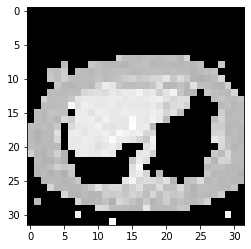

In [63]:
# get image
image_dcm = sitk.ReadImage('data/IMG-0002-00074.dcm');
image_array_view = sitk.GetArrayViewFromImage(image_dcm)
image = image_array_view.squeeze()

# scale down image
scaling_factor = 16
image = scipy.ndimage.affine_transform(image, matrix=[[scaling_factor, 0], [0, scaling_factor]], offset=0, output_shape=(int(image.shape[0]/scaling_factor), int(image.shape[1]/scaling_factor)))

# clip values to range -160 <-> 240, which is the intensity values of blood-filled organs.
image[image < -160] = -1024
image[image > 240] = -1024

image = np.sqrt((image+np.abs(np.min(image)))**2) # add an offset and 'remove' negative values
image = image/np.max(image) # normalize

# plot image
plt.imshow(image, cmap='gray');

In [64]:
# similarity matrix - nodes are connected if they are neighbours and they share the same value
num_pixels = image.size

similarity_matrix = np.zeros((num_pixels,num_pixels),dtype=float)

image_width = image.shape[0]

max_distance = 5

sigma_distance = int(0.1 * image_width) # 10-20% of feature distance
sigma_intensity = 102 # 10-20% of feature distance (-1024 <-> 1024)

for i in range(0,image_width):
    for j in range(0,image_width):
        sm_i = j + i * image_width
        for ii in range(0,image_width):
            for jj in range(0,image_width):
                sm_j = jj + ii * image_width

                distance = np.linalg.norm(np.array([i,j]) - np.array([ii,jj]))

                if distance > max_distance:
                    similarity_matrix[sm_i,sm_j] = 0
                else:
                    intensity_diff = np.linalg.norm(np.array(image[i,j]) - np.array(image[ii,jj]))
                    weight = np.exp(-np.power(intensity_diff,2)/sigma_intensity) * np.exp(-np.power(distance,2)/sigma_distance)
                    similarity_matrix[sm_i,sm_j] = weight


In [57]:

# debug purposes
np.savetxt("similarity.csv", similarity_matrix, fmt='%i', delimiter=",")
print(similarity_matrix)

[[1.         0.71653131 0.26359714 ... 0.         0.         0.        ]
 [0.71653131 1.         0.71653131 ... 0.         0.         0.        ]
 [0.26359714 0.71653131 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.71653131 0.26359714]
 [0.         0.         0.         ... 0.71653131 1.         0.71653131]
 [0.         0.         0.         ... 0.26359714 0.71653131 1.        ]]


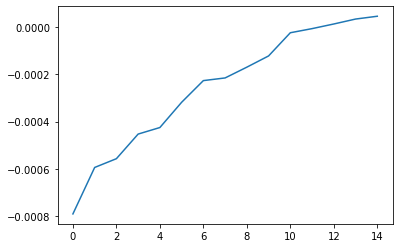

In [69]:
# get eigenvalues + vectors
eigenvalues, eigenvectors = np.linalg.eig(similarity_matrix)

ind = np.argsort(eigenvalues, axis=0)

eigenvalues = eigenvalues[ind]
eigenvectors = eigenvectors[:,ind] # TODO: Is this the eigenvectors that we want, or do we need to do it as they do in the paper???

plt.plot(eigenvalues[0:15])

In [73]:
# compute D matrix (diagonal matrix with node's connection to all other nodes)
D = np.zeros(similarity_matrix.shape)

for i in range(0, similarity_matrix.shape[0]):
    tot_weight = 0
    for j in range(0, similarity_matrix.shape[1]):
        tot_weight += similarity_matrix[i][j]
    D[i,i] = tot_weight

# calc total weight of edges between clusters
# A and B are index arrays (indicating the row)
def get_cut_value(similarity_matrix,A,B):
    cut_value = 0
    for a in A:
        for b in B:
            cut_value += similarity_matrix[a,b]
    return cut_value

# calc total weight of edges between nodes in A and all other nodes
# A is an index array (indicating the row)
def get_assoc_value(D, A):
    assoc_value = 0
    for a in A:
        assoc_value += D[a,a]
    return assoc_value

# get eigenvector for second smallest eigenvalue
eigenvector = eigenvectors[:,1]

step_size = int(eigenvector.shape[0] / 10)

best_cut = (0,0)
for i in range(step_size,eigenvector.shape[0],step_size):
    A = range(0,i)
    B = range(i,eigenvector.shape[0])
    cut_value = get_cut_value(similarity_matrix,A,B)
    n_cut = (cut_value / get_assoc_value(D, A)) + (cut_value / get_assoc_value(D, B))

    if best_cut[0] == 0 or best_cut[0] > n_cut:
        best_cut = (n_cut,i)

print(best_cut)

102 0.18688738793773116
204 0.09710145657638358
306 0.07221063431710682
408 0.06256658141432528
510 0.05981050863094528
612 0.06236230812852082
714 0.07157969888187932
816 0.09539811099615716
918 0.17923934377025447
1020 0.5735127574938536
(0.05981050863094528, 510)


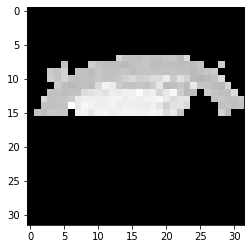

In [74]:
# similarity matrix => image
best_cut_indexes = range(0, best_cut[1])

cluster_image = np.zeros(image.shape)

for i in best_cut_indexes:
    x = i % image_width
    y = int(i / image_width)
    cluster_image[y,x] = image[y,x]

# plot image
plt.imshow(cluster_image, cmap='gray');